**<h1 align="center">Malaria Detection - PyTorch</h1>**

<p align="center"><i>V1.3 - Added Checkpoints</i></p>

## Pip installs & Imports

### Uncomment the following lines to install the required packages during first run

In [181]:
# !pip install kagglehub
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install torch torchvision
# !pip install tqdm

### Imports

In [182]:
# For data download
import kagglehub

# For data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For deep learning (PyTorch)
import torch
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets, models
from torchvision.models import ResNet50_Weights
from torchvision.transforms import functional as F

# For progress tracking
from tqdm import tqdm

# Miscellaneous / Utilities
import random
import shutil
import os

## Global variables

### Project specific variables

In [183]:
# Hyperparameters
IMG_SIZE = 224  # Resize all images to defined size
BATCH_SIZE = 32
N_EPOCHS = 50
PATIENCE = 5  # Number of epochs with no improvement before early stopping
LEARNING_RATE = 0.001
NUM_CLASSES = 2

# Split ratios
VALIDATION_SIZE = 0.2
TEST_SIZE = 0.2

# Device selection
DEVICE = 'GPU'  # Options: 'TPU', 'GPU', 'CPU'
USE_MODEL = 'ultrafast'  # Options: 'resnet50', 'custom', 'simple', 'ultrafast', 'seb'

# Data source selection
SOURCE = 'kaggle'
DATA_DIR = 'src/static/data'

# Model saving
MODEL_DIR = "src/static/model/"
MODEL_NAME = 'best_model.pt'
MODEL_PATH = MODEL_DIR + MODEL_NAME

### Colors

In [184]:
# ANSI escape codes for colored output
GREEN = "\033[92m"
BLUE = "\033[94m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"  # White

## Device Selector

In [185]:
# Device selector
if DEVICE.upper() == 'TPU':
    try:
        import torch_xla
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
        actual_device = 'TPU'
    except ImportError:
        raise ImportError("TPU support requires torch_xla. Make sure you're running on a TPU environment like Google Colab.")
elif DEVICE.upper() == 'GPU':
    if torch.cuda.is_available():
        device = torch.device('cuda')
        actual_device = 'GPU'
    else:
        device = torch.device('cpu')
        actual_device = 'CPU (fallback)'
        use_cuda = False
elif DEVICE.upper() == 'CPU':
    device = torch.device('cpu')
    actual_device = 'CPU'
    use_cuda = False
else:
    raise ValueError("Invalid DEVICE value. Choose from: 'TPU', 'GPU', 'CPU'.")

print(f"{YELLOW}Using device: {RESET}{actual_device}")

Using device: CPU (fallback)


## Data source

In [186]:
if SOURCE == 'kaggle':
    # Download dataset
    downloaded_path = kagglehub.dataset_download('iarunava/cell-images-for-detecting-malaria')

    # This is where the actual images live
    source_path = os.path.join(downloaded_path, 'cell_images')

    # Sanity check: skip top-level duplicates
    top_level_dupes = ['Parasitized', 'Uninfected']
    for folder in top_level_dupes:
        dupe_path = os.path.join(downloaded_path, folder)
        if os.path.exists(dupe_path):
            print(f"{YELLOW}Skipping top-level duplicate: {RESET}{dupe_path}")

    # Ensure target directory exists
    os.makedirs(DATA_DIR, exist_ok=True)

    # Clean up nested 'cell_images' in the target dir if it already exists
    nested_path = os.path.join(DATA_DIR, 'cell_images')
    if os.path.exists(nested_path):
        print(f"{YELLOW}Removing nested folder: {RESET}{nested_path}")
        shutil.rmtree(nested_path)

    # Define allowed folders to copy (explicitly skip weird ones)
    allowed_folders = ['Parasitized', 'Uninfected']

    # Only copy those two
    for folder in allowed_folders:
        src_folder = os.path.join(source_path, folder)
        dst_folder = os.path.join(DATA_DIR, folder)
        if os.path.isdir(src_folder):
            if not os.path.exists(dst_folder):
                print(f"{YELLOW}Copying {RESET}{folder} {YELLOW}to {RESET}{dst_folder}")
                shutil.copytree(src_folder, dst_folder)
            else:
                print(f"{YELLOW}Skipping existing folder: {RESET}{dst_folder}")
# elif SOURCE == 'local':
#     DATA_DIR = DATA_DIR + '/cell_images/'
else:
    raise ValueError("Invalid SOURCE value. Choose from: 'kaggle', 'local'")

print(f"\n{YELLOW}Data source:{RESET}")
print(DATA_DIR)

print(f"\n{YELLOW}Labels found:{RESET}")
print(os.listdir(DATA_DIR))
# print(os.listdir(DATA_DIR + '/cell_images/'))

Skipping existing folder: src/static/data\Parasitized
Skipping existing folder: src/static/data\Uninfected

Data source:
src/static/data

Labels found:
['Parasitized', 'Uninfected']


In [187]:
# Define your transforms for the training, validation, and testing sets

# Custom transform for adding Gaussian noise
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

# Train/Validation/Test Transforms

train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.RandomVerticalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.5),  # Random brightness and contrast
    transforms.ToTensor(),
    # AddGaussianNoise(0., 0.02),            # Add noise
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225])
])

print(f"{GREEN}Transforms Defined.{RESET}")

Transforms Defined.


## Load Dataset and Split

In [188]:
img_dir=DATA_DIR
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

print(f"{GREEN}Data loaded and transformed.{RESET}")

Data loaded and transformed.


In [189]:
# number of subprocesses to use for data loading
num_workers = 0

# percentage of training set to use as validation
valid_size = 0.2

# Percentage of training set to use as test
test_size = 0.1

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(f"{BLUE}Total length:{RESET}")
print(num_train)
print(f"\n{GREEN}Train length:{RESET}")
print(len(train_idx))
print(f"\n{YELLOW}Validation length:{RESET}")
print(len(valid_idx))
print(f"\n{YELLOW}Test length:{RESET}")
print(len(test_idx))

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=20, sampler=test_sampler, num_workers=num_workers)

Total length:
27558

Train length:
19291

Validation length:
5511

Test length:
2756


## Model Selection

### Small custom model

In [190]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),  # 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Use dummy input of size 224x224 to match transforms
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            dummy_output = self.conv_layers(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]
            print(f"[DEBUG] Flattened size: {self.flattened_size}")

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Fewer filters
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
        )

        # Dynamically calculate the flattened size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            dummy_output = self.conv_layers(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]
            print(f"[DEBUG] Flattened size: {self.flattened_size}")

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


class UltraFastCNN(nn.Module):
    def __init__(self):
        super(UltraFastCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),  # Way fewer filters
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            dummy_output = self.conv_layers(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]
            print(f"[DEBUG] Flattened size: {self.flattened_size}")

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


class Model_Seb(nn.Module):
    def __init__(self, num_classes=2):
        super(Model_Seb, self).__init__()

        # Bloc convolutif
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
        )

        # GAP
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Calcul dynamique de la taille d'entrée pour les couches fully connected
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 128, 128)
            dummy_output = self.gap(self.conv_layers(dummy_input))
            self.flattened_size = dummy_output.view(1, -1).shape[1]
            print(f"[DEBUG] Flattened size: {self.flattened_size}")

        # Bloc de couches entièrement connectées
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

### ResNet50 Model

In [191]:
# model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# for param in model.parameters():
#     param.requires_grad = False

# model.fc = nn.Linear(2048, 2, bias=True)

# fc_parameters = model.fc.parameters()

# for param in fc_parameters:
#     param.requires_grad = True

# print(f"{GREEN}Model loaded.{RESET}\n")

# model # Display Model details - comment out if not needed

### Model selector

In [192]:
if USE_MODEL == 'resnet50':
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Linear(2048, NUM_CLASSES)
    for param in model.fc.parameters():
        param.requires_grad = True

    optimizer = optim.SGD(model.fc.parameters(), lr=LEARNING_RATE, momentum=0.9)

elif USE_MODEL == 'custom':
    # model = CNNModel(num_classes=NUM_CLASSES)
    model = CNNModel()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

elif USE_MODEL == 'simple':
    # model = CNNModel(num_classes=NUM_CLASSES)
    model = SimpleCNN()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

elif USE_MODEL == 'ultrafast':
    # model = CNNModel(num_classes=NUM_CLASSES)
    model = UltraFastCNN()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

elif USE_MODEL == 'seb':
    # model = CNNModel(num_classes=NUM_CLASSES)
    model = Model_Seb()
    # optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

else:
    raise ValueError(f"Unknown model type: {USE_MODEL}")

criterion = nn.CrossEntropyLoss()

print(f"{USE_MODEL.upper()} - {GREEN}Model loaded successfully.{RESET}\n")

[DEBUG] Flattened size: 100352
ULTRAFAST - Model loaded successfully.



In [193]:
if actual_device == 'GPU': # See later if I can relocate this to Model selection
    use_cuda = torch.cuda.is_available()

    if use_cuda:
        model = model.cuda()

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.fc.parameters(), lr=LEARNING_RATE , momentum=0.9)

# print(f"{GREEN}Cross entropy loss and SGD optimizer loaded.{RESET}\n")

## Model Training

In [194]:

import os
import torch

def load_checkpoint(save_path, model, optimizer):
    if os.path.exists(save_path):
        print(f"{YELLOW}Checkpoint found! Resuming training...{RESET}")
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return (checkpoint['epoch'] + 1,
                checkpoint['valid_loss_min'],
                checkpoint['epochs_no_improve'])
    else:
        return 1, float('inf'), 0

def train(n_epochs, model, optimizer, criterion, use_cuda, save_path, patience=5):
    """Train model with early stopping, tqdm, and accuracy tracking."""
    
    # Load checkpoint if exists
    start_epoch, valid_loss_min, epochs_no_improve = load_checkpoint(save_path, model, optimizer)

    valid_loss_min = np.inf
    epochs_no_improve = 0
    best_model_wts = None
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_val = 0
        total_val = 0

        ###################
        # train the model #
        ###################
        model.train()
        train_loader_tqdm = tqdm(train_loader, desc=f"{YELLOW}Epoch {RESET}{epoch}/{n_epochs} [{YELLOW}Training{RESET}]", leave=False)

        for batch_idx, (data, target) in enumerate(train_loader_tqdm):
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # Accuracy
            _, predicted = torch.max(output.data, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)

            train_loader_tqdm.set_postfix(loss=train_loss.item())

        ######################
        # validate the model #
        ######################
        model.eval()
        with torch.no_grad():
            valid_loader_tqdm = tqdm(valid_loader, desc=f"{GREEN}Epoch {RESET}{epoch}/{n_epochs} [{GREEN}Validation{RESET}]", leave=False)

            for batch_idx, (data, target) in enumerate(valid_loader_tqdm):
                if use_cuda:
                    data, target = data.cuda(), target.cuda()

                output = model(data)
                loss = criterion(output, target)
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

                # Accuracy
                _, predicted = torch.max(output.data, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

                valid_loader_tqdm.set_postfix(val_loss=valid_loss.item())

        # Accuracy calculations
        train_accuracy = 100 * correct_train / total_train
        val_accuracy = 100 * correct_val / total_val

        # Save stats
        train_losses.append(train_loss.item())
        val_losses.append(valid_loss.item())
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Print stats
        print(f"{GREEN}Epoch: {RESET}{epoch} "
              f"\t{BLUE}Train Loss: {RESET}{train_loss:.6f} | {BLUE}Train Acc: {RESET}{train_accuracy:.2f}% "
              f"\t{BLUE}Val Loss: {RESET}{valid_loss:.6f} | {BLUE}Val Acc: {RESET}{val_accuracy:.2f}%")

        ########################
        # early stopping check #
        ########################
        if valid_loss < valid_loss_min:
            # torch.save(model.state_dict(), save_path)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_loss_min': valid_loss_min,
                'epochs_no_improve': epochs_no_improve,
            }, save_path)
            print(f"{YELLOW}Validation loss decreased {RESET}({valid_loss_min:.6f} --> {valid_loss:.6f}). {YELLOW}Saving model...{RESET}\n")
            valid_loss_min = valid_loss
            epochs_no_improve = 0
            best_model_wts = model.state_dict()
        else:
            epochs_no_improve += 1
            print(f"{YELLOW}No improvement in validation loss for {epochs_no_improve} epoch(s).{RESET}\n")

        if epochs_no_improve >= patience:
            print(f"\n{YELLOW}Early stopping triggered after {patience} epochs with no improvement.{RESET}")
            break

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [195]:
# Display selected device
print(f"{YELLOW}Using device: {RESET}{actual_device}")

Using device: CPU (fallback)


In [196]:
# Check if folder exists, and create it if it doesn't
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"{YELLOW}Created directory: {RESET}{MODEL_DIR}\n")
else:
    print(f"{YELLOW}Directory already exists: {RESET}{MODEL_DIR}\n")

# Start Model Training
# train(25, model, optimizer, criterion, use_cuda, 'malaria_detection.pt') # Old Model
# trained_model = train(25, model, optimizer, criterion, use_cuda, save_path=MODEL_PATH, patience=3)

model, train_losses, val_losses, train_acc, val_acc = train(
    n_epochs=N_EPOCHS,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    use_cuda=use_cuda,
    save_path=MODEL_PATH,
    patience=PATIENCE
)

Directory already exists: src/static/model/



Epoch: 1 	Train Loss: 0.641378 | Train Acc: 63.53% 	Val Loss: 0.646849 | Val Acc: 63.04%
Validation loss decreased (inf --> 0.646849). Saving model...



Epoch: 2 	Train Loss: 0.614966 | Train Acc: 67.04% 	Val Loss: 0.598315 | Val Acc: 69.01%
Validation loss decreased (0.646849 --> 0.598315). Saving model...



Epoch: 3 	Train Loss: 0.592097 | Train Acc: 69.34% 	Val Loss: 0.578115 | Val Acc: 71.17%
Validation loss decreased (0.598315 --> 0.578115). Saving model...



Epoch: 4 	Train Loss: 0.557492 | Train Acc: 72.85% 	Val Loss: 0.582624 | Val Acc: 70.22%
No improvement in validation loss for 1 epoch(s).



Epoch: 5 	Train Loss: 0.513497 | Train Acc: 76.39% 	Val Loss: 0.541329 | Val Acc: 75.67%
Validation loss decreased (0.578115 --> 0.541329). Saving model...



Epoch: 6 	Train Loss: 0.559175 | Train Acc: 71.29% 	Val Loss: 0.452209 | Val Acc: 81.20%
Validation loss decreased (0.541329 --> 0.452209). Saving model...



Epoch: 7 	Train Loss: 0.578928 | Train Acc: 66.07% 	Val Loss: 0.659696 | Val Acc: 62.53%
No improvement in validation loss for 1 epoch(s).



Epoch: 8 	Train Loss: 0.653142 | Train Acc: 64.31% 	Val Loss: 0.641216 | Val Acc: 65.74%
No improvement in validation loss for 2 epoch(s).



Epoch: 9 	Train Loss: 0.602664 | Train Acc: 68.67% 	Val Loss: 0.436125 | Val Acc: 81.15%
Validation loss decreased (0.452209 --> 0.436125). Saving model...



Epoch: 10 	Train Loss: 0.432743 | Train Acc: 81.22% 	Val Loss: 0.442422 | Val Acc: 81.76%
No improvement in validation loss for 1 epoch(s).



Epoch: 11 	Train Loss: 0.418254 | Train Acc: 82.15% 	Val Loss: 0.401218 | Val Acc: 82.58%
Validation loss decreased (0.436125 --> 0.401218). Saving model...



Epoch: 12 	Train Loss: 0.686552 | Train Acc: 51.23% 	Val Loss: 0.693614 | Val Acc: 49.59%
No improvement in validation loss for 1 epoch(s).



Epoch: 13 	Train Loss: 0.693398 | Train Acc: 49.86% 	Val Loss: 0.692820 | Val Acc: 50.35%
No improvement in validation loss for 2 epoch(s).



Epoch: 14 	Train Loss: 0.693891 | Train Acc: 50.12% 	Val Loss: 0.693478 | Val Acc: 49.65%
No improvement in validation loss for 3 epoch(s).



Epoch: 15 	Train Loss: 0.693281 | Train Acc: 49.72% 	Val Loss: 0.692317 | Val Acc: 51.84%
No improvement in validation loss for 4 epoch(s).



                                                                                           s, val_loss=0.652]

Epoch: 16 	Train Loss: 0.665358 | Train Acc: 60.95% 	Val Loss: 0.652346 | Val Acc: 64.27%
No improvement in validation loss for 5 epoch(s).


Early stopping triggered after 5 epochs with no improvement.


## Display Training Metrics

In [197]:
def plot_training_metrics(train_losses, val_losses, train_acc, val_acc):
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(epochs, train_losses, label='Training Loss')
    ax1.plot(epochs, val_losses, label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(epochs, train_acc, label='Training Accuracy')
    ax2.plot(epochs, val_acc, label='Validation Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

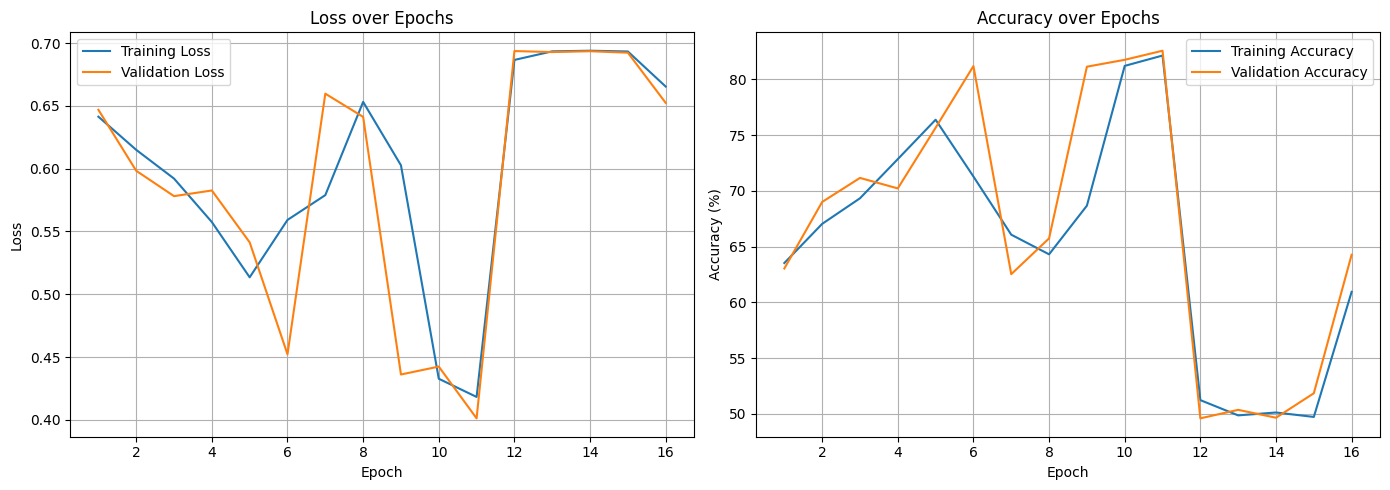

In [198]:
# Display training metrics
plot_training_metrics(train_losses, val_losses, train_acc, val_acc)